## Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

* Nama: Aqilah Nurfaidah Ammardinah
* Email: aqilahnfard@gmail.com
* Id Dicoding: @nuffavoy


In [1]:
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
if tf.config.list_physical_devices('GPU'):
  print('GPU is available')
else:
  print('GPU is not available')


GPU is available


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/aqilahnuffa/mysource/main/weatherHistory.csv")
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [4]:
df = df.drop(columns=["Precip Type", "Summary", "Humidity", "Loud Cover",
                      "Wind Speed (km/h)", "Wind Bearing (degrees)",
                      "Visibility (km)", "Pressure (millibars)", "Daily Summary",
                      "Apparent Temperature (C)"])


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Formatted Date   96453 non-null  object 
 1   Temperature (C)  96453 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [6]:
df.describe()

,Temperature (C)
count,96453.000000
mean,11.932678
std,9.551546
min,-21.822222
25%,4.688889
50%,12.000000
75%,18.838889
max,39.905556


In [7]:
df.isna().sum()

Formatted Date     0
Temperature (C)    0
dtype: int64

In [8]:
new_names = {'Formatted Date': 'date', 'Temperature (C)': 'temp'}
df = df.rename(columns=new_names)
df

,date,temp
0,2006-04-01 00:00:00.000 +0200,9.472222
1,2006-04-01 01:00:00.000 +0200,9.355556
2,2006-04-01 02:00:00.000 +0200,9.377778
3,2006-04-01 03:00:00.000 +0200,8.288889
4,2006-04-01 04:00:00.000 +0200,8.755556
...,...,...
96448,2016-09-09 19:00:00.000 +0200,26.016667
96449,2016-09-09 20:00:00.000 +0200,24.583333
96450,2016-09-09 21:00:00.000 +0200,22.038889
96451,2016-09-09 22:00:00.000 +0200,21.522222


In [9]:
def reformat_date(date_str):
  date_obj = datetime.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S.%f %z")
  return date_obj.strftime("%Y-%m-%d")

df['date'] = df['date'].apply(reformat_date)
df['date'] = pd.to_datetime(df['date'])


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df = pd.DataFrame({
    "date": df['date'],
    "temp": df['temp']
})

result = df.groupby('date').agg(date=('date', 'mean'), temp=('temp', 'mean'))

df = pd.DataFrame(result)

In [12]:
date = df['date'].values
temp = df['temp'].values

In [13]:
threshold_mae = (df['temp'].max() - df['temp'].min()) * 10/100
threshold_mae

4.630509259259259

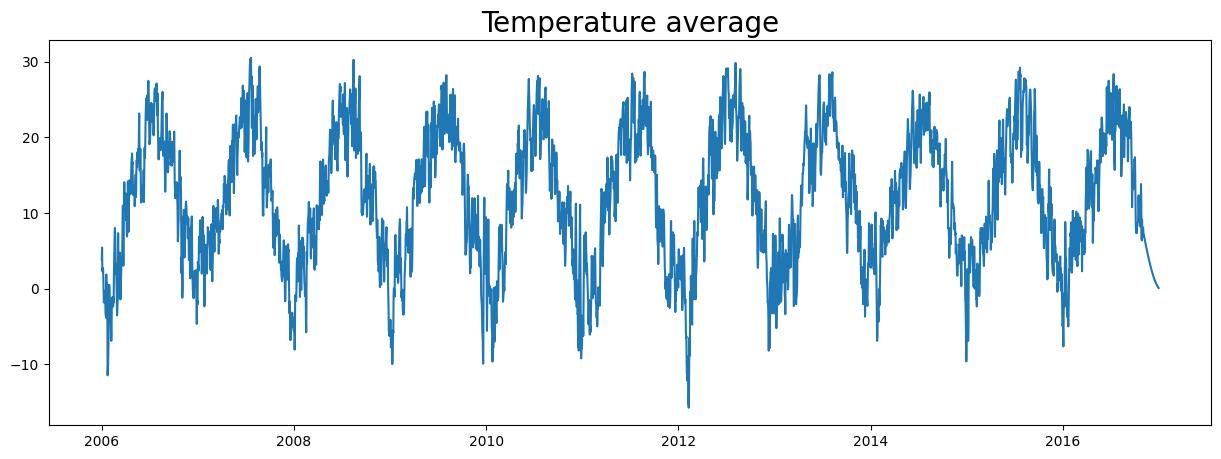

In [14]:
plt.figure(figsize=(15,5))
plt.plot(date, temp)
plt.title('Temperature average',
          fontsize=20);

In [15]:
date_train, date_test, temp_train, temp_test = train_test_split(date, temp, test_size=0.2, shuffle=False)

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [43]:
temp_rain_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
temp_test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Reshape((60, 1), input_shape=(60, 1, 1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.LSTM(40),
  tf.keras.layers.Dense(20, kernel_regularizer=regularizers.l2(0.01)),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [44]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [45]:
class callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold_mae):
      print("\MAE telah mencapai <10%")
      self.model.stop_training = True

stops = callbacks()


history = model.fit(temp_rain_set,
                    validation_data=temp_test_set,
                    batch_size=15,
                    epochs=50,
                    callbacks=[stops])

Epoch 1/50
32/32 [==============================] - 7s 56ms/step - loss: 7.6004 - mae: 7.8169 - val_loss: 3.3492 - val_mae: 3.5537
Epoch 2/50
32/32 [==============================] - 1s 24ms/step - loss: 3.0801 - mae: 3.2961 - val_loss: 2.4846 - val_mae: 2.7024


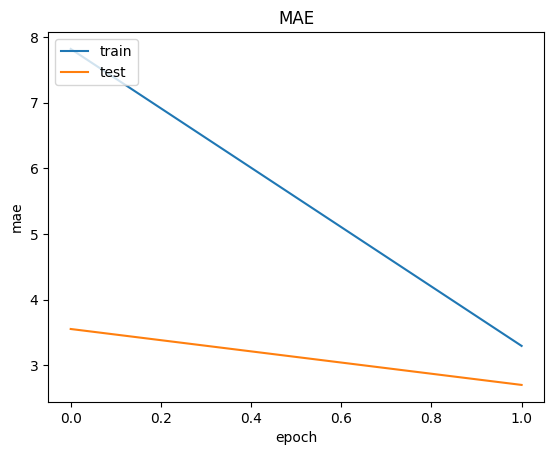

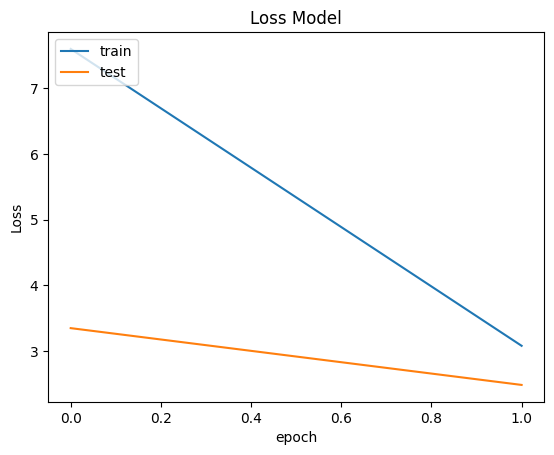

In [46]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()